<a href="https://colab.research.google.com/github/ducquanhp28112002/Machine_Learning/blob/main/OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Khai báo thư viện**

In [348]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [349]:
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### **Đọc dữ liệu**

In [350]:
df = pd.read_csv("OnlineRetail.csv", delimiter = ",", encoding = "ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### **Tìm hiểu về dữ liệu**

In [351]:
# Kích thước
df.shape

(541909, 8)

In [352]:
# Thông tin
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [353]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### **Làm sạch dữ liệu**

In [354]:
df_null = round(100 * (df.isnull().sum()) / len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [355]:
# Xóa dòng có dữ liệu bị thiếu
df = df.dropna()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [356]:
# Chuyển đổi định dạng của cột "CustomerID"
df['CustomerID'] = df['CustomerID'].astype(str)

### **Phân tích RFM**

- R (Recency): Số ngày kể từ lần mua gần đây nhất.
- F (Frequency): Số lần mua (Tần suất).
- M (Monetary): Doanh thu

In [357]:
df['Amount'] = df['Quantity'] * df['UnitPrice']
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [358]:
rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [359]:
# Hợp nhất hai DataFrame trên
rfm = pd.merge(rfm_m, rfm_f, on = 'CustomerID', how = 'inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [360]:
# Chuyển đổi định dạng của cột "InvoiceDate"
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format = "%d-%m-%Y %H:%M")

In [361]:
# Xem ngày bán cuối cùng trong dữ liệu trên
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [362]:
# Thêm cột chỉ khoảng cách giữa ngày mua với last_date
df['Diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [363]:
rfm_p = df.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [364]:
# Cột "Dis" chỉ lấy ngày
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [365]:
# Gộp ba DataFrame lại với nhau
rfm = pd.merge(rfm, rfm_p, on = 'CustomerID', how = 'inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


### **Xử lý dữ liệu ngoại lai**

Text(0.5, 0, 'Attributes')

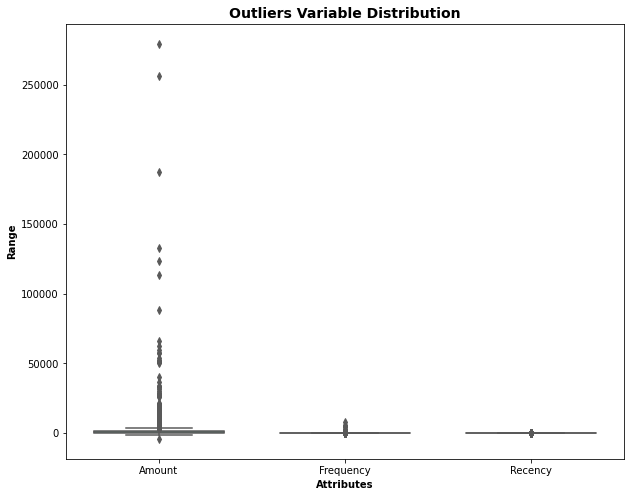

In [366]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data = rfm[attributes], orient = "v", palette = "Set2", whis = 1.5, saturation = 1, width = 0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [367]:
# Loại bỏ dữ liệu ngoại lai
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5 * IQR) & (rfm.Amount <= Q3 + 1.5 * IQR)]

In [368]:
# Loại bỏ dữ liệu ngoại lai
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5 * IQR) & (rfm.Recency <= Q3 + 1.5 * IQR)]

In [369]:
# Loại bỏ dữ liệu ngoại lai
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5 * IQR) & (rfm.Frequency <= Q3 + 1.5 * IQR)]

In [370]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [371]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


### **K - Means Clustering**

In [372]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters = 4, max_iter = 100)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=100, n_clusters=4)

In [373]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

##### *Phương pháp Elbow*

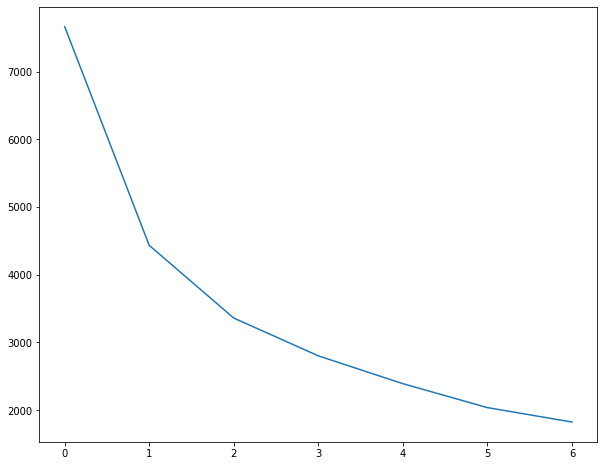

In [374]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, max_iter = 100)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

##### *Sihouette Analysis*

silhoutte score = $\frac{p - q}{max(p, q)}$

$p$ là khoảng cách trung bình đến các điểm trong cụm gần nhất mà điểm dữ liệu không phải là một phần của cụm đó.
$q$ là khoảng cách trung bình từ điểm dữ liệu trong cụm đến tất cả các điểm trong cụm của chính nó.

In [375]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter = 100)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters = {0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters = 2, the silhouette score is 0.5411246404292333
For n_clusters = 3, the silhouette score is 0.5084896296141937
For n_clusters = 4, the silhouette score is 0.4777820100216849
For n_clusters = 5, the silhouette score is 0.46627005641897035
For n_clusters = 6, the silhouette score is 0.41753051875511704
For n_clusters = 7, the silhouette score is 0.41550117171171014
For n_clusters = 8, the silhouette score is 0.41034011379914037


In [376]:
# Final model with k = 3
kmeans = KMeans(n_clusters = 3, max_iter = 100)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=100, n_clusters=3)

In [377]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

In [378]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


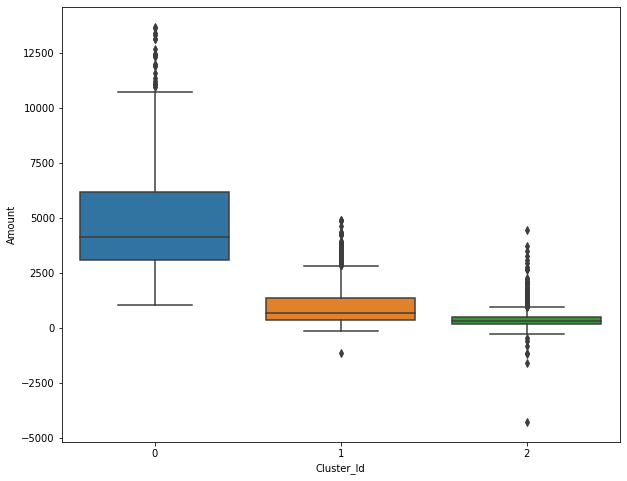

In [379]:
# Vẽ biểu đồ boxplot cho thuộc tính "Cluster_Id" và "Amount"
sns.boxplot(x = "Cluster_Id", y = "Amount", data = rfm)

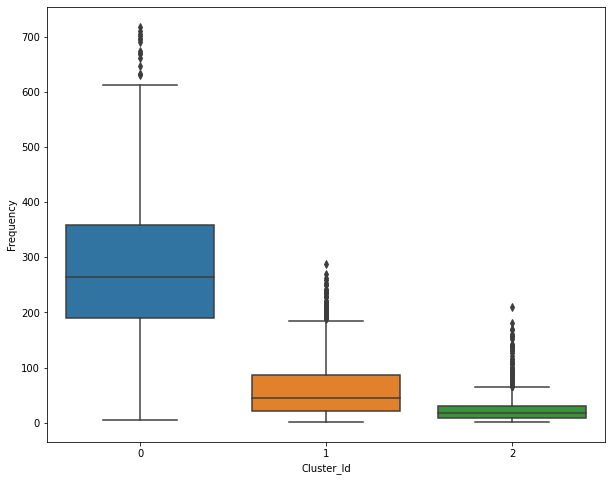

In [380]:
# Vẽ biểu đồ boxplot cho thuộc tính "Cluster_Id" và "Frequency"
sns.boxplot(x = "Cluster_Id", y = "Frequency", data = rfm)

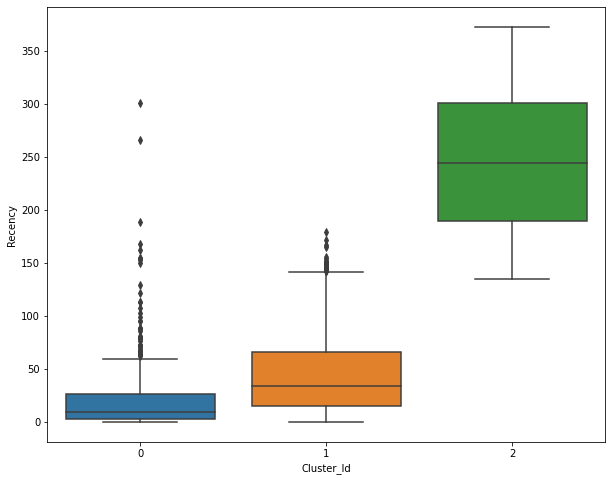

In [381]:
# Vẽ biểu đồ boxplot cho thuộc tính "Cluster_Id" và "Recency"
sns.boxplot(x = "Cluster_Id", y = "Recency", data = rfm)

##### *Nhận xét*

- Khách hàng có Cluster_Id cụm 0 có lượng mua cao hơn so với các khách hàng khác.
- Khách hàng có Cluster_Id cụm 0 là những người mua thường xuyên nhất.
- Khách hàng có Cluster_Id cụm 2 không phải là những người mua gần đây nhiều. Từ đó dẫn đến đây là những đối tượng ít quan trọng trong chiến lược bán hàng.

### Hierarchical Clustering

Phân cum có thứ bậc giúp tạo ra các cụm có thứ tự từ trên xuống dưới.

##### *Liên kết đơn*
Khoảng cách giữa hai cụm được xác định là khoảng cách ngắn nhất giữa hai điểm thuộc hai cụm đó

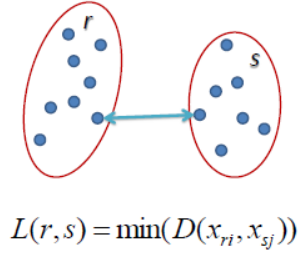

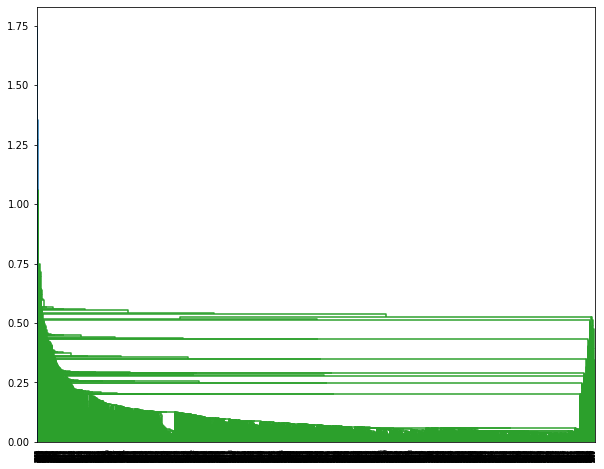

In [382]:
mergings = linkage(rfm_df_scaled, method = "single", metric = 'euclidean')
dendrogram(mergings)
plt.show()

##### *Liên kết hoàn chỉnh*
Khoảng cách giữa hai cụm được xác định là khoảng cách xa nhất giữa hai điểm thuộc hai cụm đó

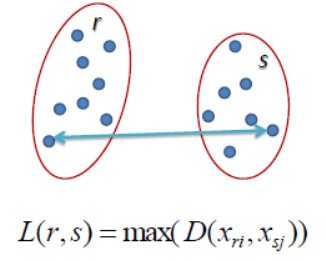

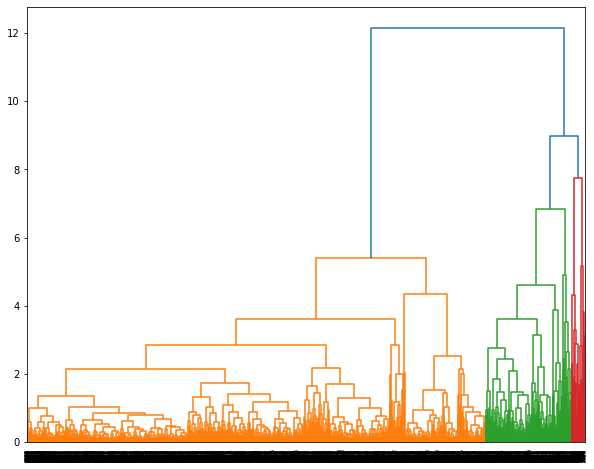

In [383]:
mergings = linkage(rfm_df_scaled, method = "complete", metric = 'euclidean')
dendrogram(mergings)
plt.show()

##### *Liên kết trung bình*
Khoảng cách giữa hai cụm được xác định là khoảng cách giữa hai điểm center của hai cụm đó (hay chính bằng trung bình khoảng cách giữa mỗi điểm trong cụm này với mọi điểm trong cụm kia).

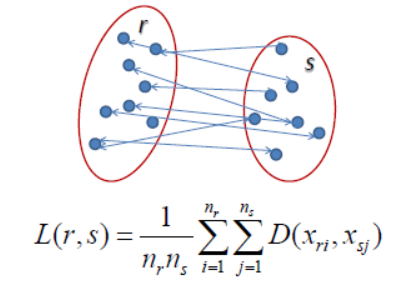

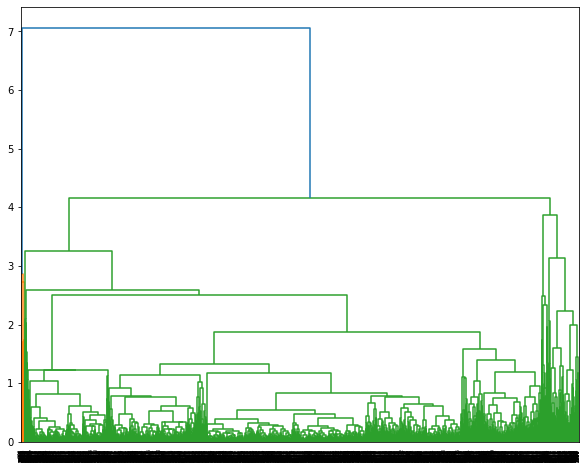

In [384]:
mergings = linkage(rfm_df_scaled, method = "average", metric = 'euclidean')
dendrogram(mergings)
plt.show()

**Cutting the Dendrogram based on K**

In [385]:
cluster_labels = cut_tree(mergings, n_clusters = 3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [386]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


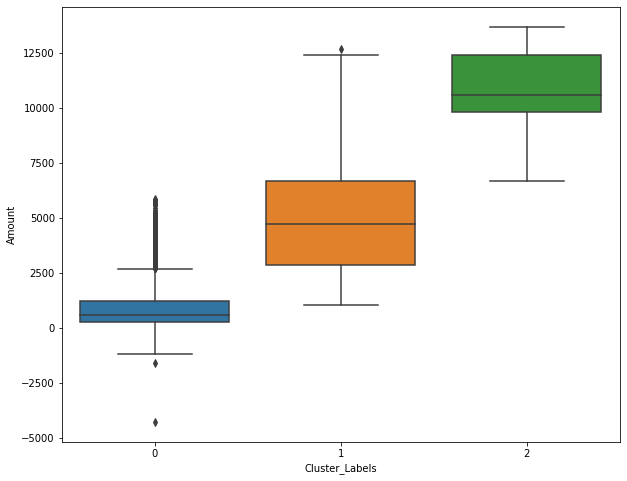

In [387]:
# Plot Cluster Id vs Amount

sns.boxplot(x = 'Cluster_Labels', y = 'Amount', data = rfm)

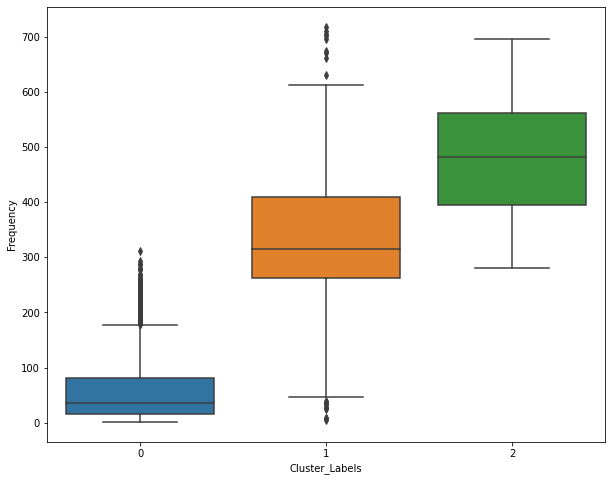

In [388]:
# Plot Cluster Id vs Frequency

sns.boxplot(x = 'Cluster_Labels', y = 'Frequency', data = rfm)

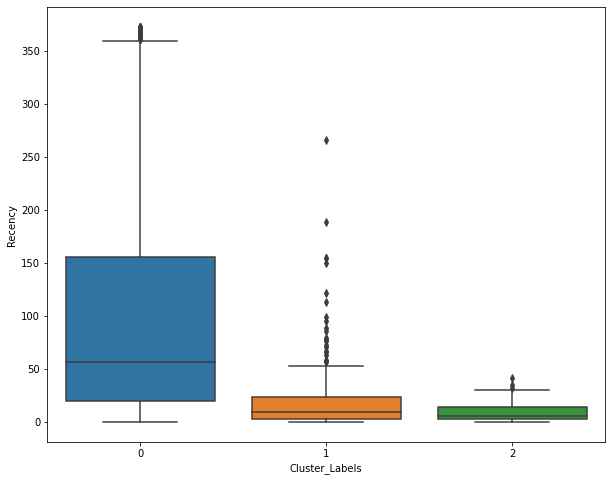

In [389]:
# Plot Cluster Id vs Recency

sns.boxplot(x = 'Cluster_Labels', y = 'Recency', data = rfm)

*Nhận xét*
- Khách hàng có Cluster_Id cụm 2 có lượng mua cao hơn so với các khách hàng khác.
- Khách hàng có Cluster_Id cụm 2 là những người mua thường xuyên nhất.
- Khách hàng có Cluster_Id cụm 0 không phải là những người mua gần đây nhiều. Từ đó dẫn đến đây là những đối tượng ít quan trọng trong chiến lược bán hàng.